# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
        
root_dir = '/home/hui/dataset/CIFAR10/'

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

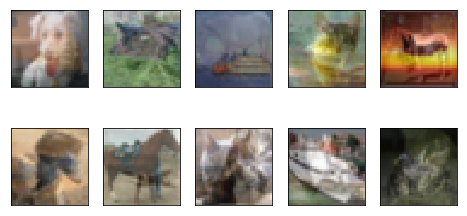

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.          0.          0.63906246
    0.          0.          0.36093757  0.        ]]

 [[ 0.          0.          0.          0.63906246  0.          0.          0.
    0.          0.          0.36093757]]

 [[ 0.          0.          0.          0.          0.          0.          0.
    0.36093757  0.63906246  0.        ]]

 [[ 0.          0.          0.          0.36093757  0.          0.
    0.63906246  0.          0.          0.        ]]

 [[ 0.63906246  0.          0.          0.          0.          0.          0.
    0.36093757  0.          0.        ]]

 [[ 0.36093757  0.          0.63906246  0.          0.          0.          0.
    0.          0.          0.        ]]

 [[ 0.36093757  0.          0.          0.          0.          0.          0.
    0.63906246  0.          0.        ]]

 [[

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [5]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [5]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data[:10], clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data, (nd.mean(loss).asscalar(),)

## 3.2 view result

In [9]:
run=False
if run:
    net = ResNet(10)
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        break
    show_data(data[:10], False)
    backgrad_data, (loss,) = generate_backgrad_data(net, data.copy(), label, max_iters=100, lr=0.1, iter_log=True, clip=False)
    print loss

## 3.3 other implement

In [10]:
if False:
    data_dict = gluon.ParameterDict()
    data_param = gluon.Parameter('data')
    data_param.set_data(data)
    data_dict.update({'data': data_param})
    data_dict['data'].set_data(data)
    trainer = gluon.Trainer(data_dict, 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    with autograd.record():
        output = net(data.as_in_context(ctx))
        loss = -loss_f(output, label.as_in_context(ctx))
    print data_dict['data'].data()
    loss.backward()
    #SGD(data, 0.1)
    import mxnet.optimizer as opt
    optimizer = opt.create('sgd', **{'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})#, param_dict=param_dict)
    updater = opt.get_updater(optimizer)

# 4. generate Folderdataset File

In [6]:
from mxnet import nd
from time import time
import os
label_text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
data_count = {}
def save_data(data, label, root_dir):
    data = data.transpose((0, 2, 3, 1))
    for i in range(data.shape[0]):
        l = label_text[int(label[i].asscalar())]
        name = os.path.join(root_dir, l)
        if not data_count.has_key(l):
            mkdir_if_not_exist([name])
            data_count[l] = 0
        name = os.path.join(root_dir, l, str(data_count[l])+'.ndarray')
        nd.save(name, data[i])
        data_count[l] += 1

## 4.1 generate origin data

iter: 0 time: 0.120635986328


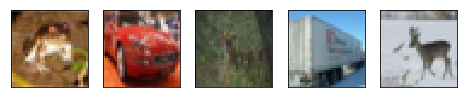

iter: 500 time: 5.95371294022


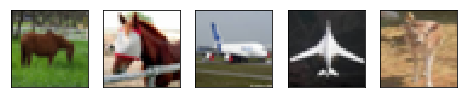

iter: 1000 time: 11.6519799232


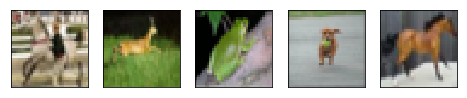

iter: 1500 time: 17.1694579124


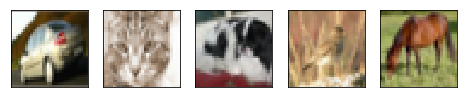

In [12]:
def save_train_origin_data(root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    
    cur_time, iters = time(), 0
    for data, label in train_data:
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        
        if iters % 500 == 0:
            print 'iter:', iters, 'time:', time() - cur_time
            show_images(data[range(0, 25, 5)])
        iters += 1

data_count = {}
save_train_origin_data(root_dir + "origin/")

## 4.2 generate backgrad image iter10

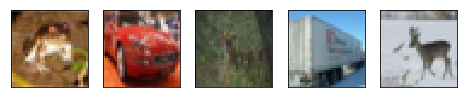

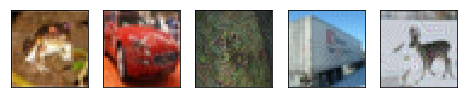

iter: 0 time: 0.826164007187 loss: -13.5021


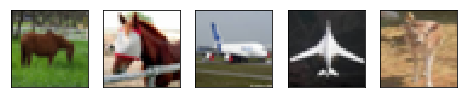

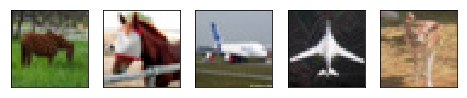

iter: 500 time: 87.5653541088 loss: -12.0789


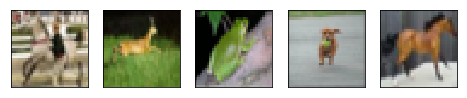

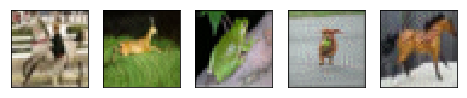

iter: 1000 time: 172.665369987 loss: -16.0794


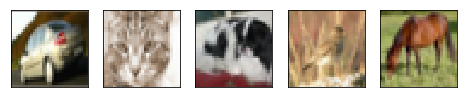

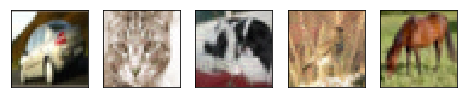

iter: 1500 time: 267.36185503 loss: -16.7082
-15.2065354594


In [13]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
root_dir2 = root_dir + '/backgrad/resnet18_me_200e_iter10'

def save_train_backgrad_data(net, root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)

    cur_time, iters, loss = time(), 0, 0.
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False))
        
        data, (_loss, ) = generate_backgrad_data(
            net, data, label, max_iters=10, lr=0.1, iter_log=False, clip=False)
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)])
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    return loss

data_count = {}
mean_loss = save_train_backgrad_data(net, root_dir2)
print mean_loss

## 4.3 generate backgrad image iter15

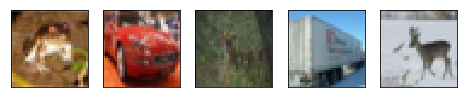

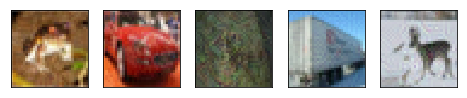

iter: 0 time: 0.777281045914 loss: -24.4299


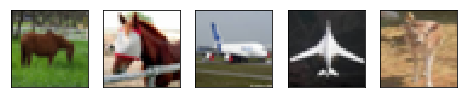

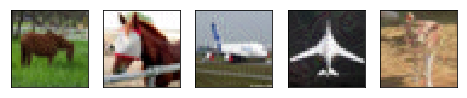

iter: 500 time: 133.815998077 loss: -21.3442


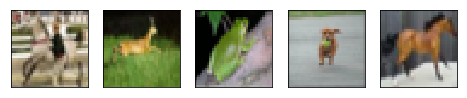

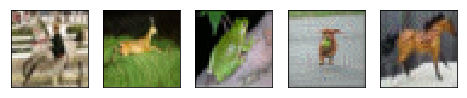

iter: 1000 time: 274.85204792 loss: -24.6436


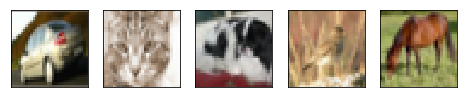

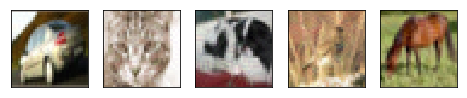

iter: 1500 time: 403.243082047 loss: -24.7234
-23.075851618


In [14]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
root_dir2 = root_dir + '/backgrad/resnet18_me_200e_iter15'

def save_train_backgrad_data(net, root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)

    cur_time, iters, loss = time(), 0, 0.
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False))
        
        data, (_loss, ) = generate_backgrad_data(
            net, data, label, max_iters=15, lr=0.1, iter_log=False, clip=False)
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)])
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    return loss

data_count = {}
mean_loss = save_train_backgrad_data(net, root_dir2)
print mean_loss

# 5. generate ArrayDaset File

## 5.1 turn Folder dataset file to ArrayDataset file

In [7]:
from dataset import *
from cifar10_utils import show_images
ArrayDataset_dir = root_dir + "/arraydataset/"
mkdir_if_not_exist([ArrayDataset_dir])

def turn_folder_to_array_ds(folder_roots, array_path):
    train_ds = MultiFolderDataset(folder_roots, transform=None)  # or use NDArrayFileDataset
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    cur_time, iters = time(), 0
    all_data, all_label, iters = None, None, 0
    for data, label in train_data:
        if all_data is None:
            all_data = data
            all_label = label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
            
        if iters % 500 == 0:
            print 'iter:', iters, 'time:', time() - cur_time
        iters += 1
    nd.save(array_path, [all_data, all_label])

In [8]:
turn_folder_to_array_ds([root_dir + '/origin/'], ArrayDataset_dir + "/origin.ndarray")

iter: 0 time: 1.44049096107
iter: 500 time: 161.650902987
iter: 1000 time: 312.603041887
iter: 1500 time: 450.819705009


In [14]:
turn_folder_to_array_ds([root_dir + '/backgrad/resnet18_me_200e_iter15/'], ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter15.ndarray")

iter: 0 time: 1.50145506859
iter: 500 time: 168.692991018
iter: 1000 time: 322.19972086
iter: 1500 time: 474.884366989


In [15]:
turn_folder_to_array_ds([root_dir + '/backgrad/resnet18_me_200e_iter10/'], ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10.ndarray")

iter: 0 time: 1.45230293274
iter: 500 time: 170.015799046
iter: 1000 time: 320.078281879
iter: 1500 time: 471.906917095


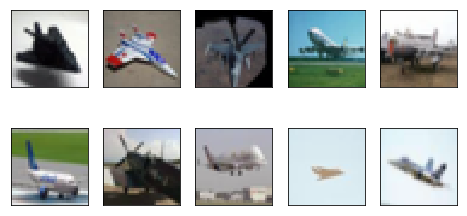

In [9]:
from dataset import MyArrayDataset
def data_loader_for_array_ds(array_file):
    datas, labels = nd.load(array_file)
    train_ds = MyArrayDataset([datas, labels], transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    return train_data

train_data = data_loader_for_array_ds(ArrayDataset_dir + "/origin.ndarray")
for data, label in train_data:
    show_images(inv_normalize(data[:10, :, :, :]))
    break

## 5.2 generate backgrad array dataset directly

In [8]:
from time import time
def save_train_backgrad_data_as_arraydataset(net, save_path, max_iters=10, lr=0.1):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    
    cur_time, iters, loss = time(), 0, 0.
    all_data, all_label, iters = None, None, 0
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False))
        
        data, (_loss, ) = generate_backgrad_data(
            net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False)
        data = nd.array(inv_normalize(data, clip=False))
        
        if all_data is None:
            all_data = data
            all_label = label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
        
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)].asnumpy())
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    nd.save(save_path, [all_data.transpose((0, 2, 3, 1)), all_label.astype('int64')])
    return loss

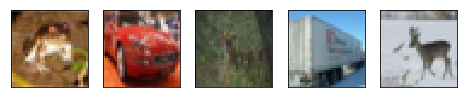

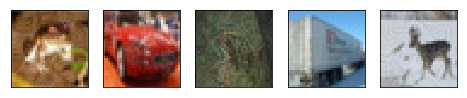

iter: 0 time: 0.815279960632 loss: -18.3402


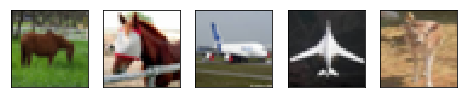

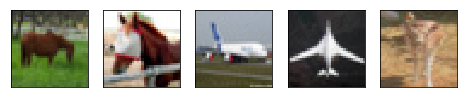

iter: 500 time: 86.930836916 loss: -10.7794


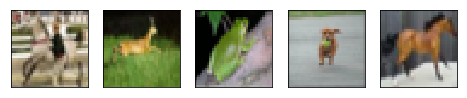

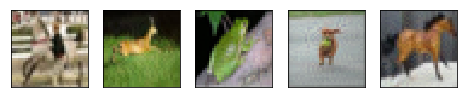

iter: 1000 time: 196.514733076 loss: -17.8794


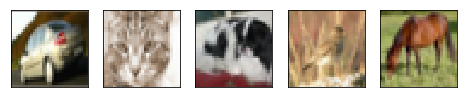

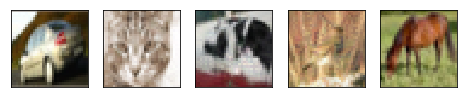

iter: 1500 time: 357.3407619 loss: -17.9416


-15.580676489126507

In [12]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
save_train_backgrad_data_as_arraydataset(net, ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10.ndarray",
                                         10, 0.1)

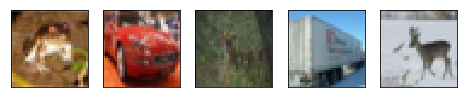

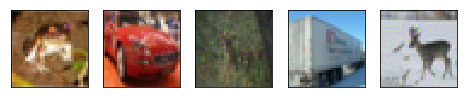

iter: 0 time: 1.05902385712 loss: -21.6895


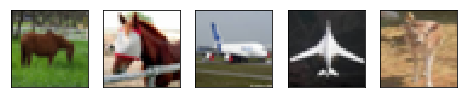

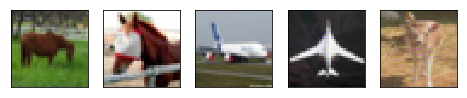

iter: 500 time: 103.715924978 loss: -19.9225


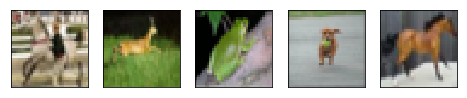

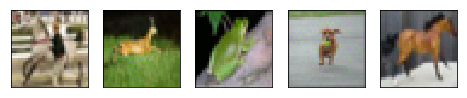

iter: 1000 time: 260.836596966 loss: -20.667


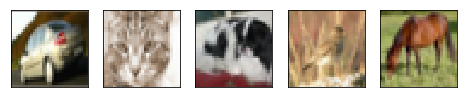

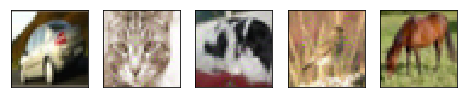

iter: 1500 time: 473.050585985 loss: -20.4787


-19.87511845635666

In [9]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad_iter10", ctx=ctx)
save_train_backgrad_data_as_arraydataset(net, ArrayDataset_dir + "/backgrad_resnet18_me_200e_backgrad_iter10_iter10.ndarray",
                                         10, 0.1)